In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
%cd /content/drive/My Drive/CV/Face_Recognition

Mounted at /content/drive
/content/drive/My Drive/CV/Face_Recognition


In [45]:
import torch 
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import cv2
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os
from google.colab.patches import cv2_imshow
import cv2
!pip install facenet-pytorch
from facenet_pytorch import MTCNN,InceptionResnetV1
from random import randint
import plotly.express as px

torch.manual_seed(2)

In [3]:
device = torch.device('cuda')


#Data preprocess


In [4]:
path = '/content/drive/My Drive/CV/Face_Recognition/dataset/train'

def read_files_to_df(path:str) -> pd.DataFrame():
  """
  input : path
  return: dataframe[paths,images,classes]
  """
  images = []
  paths = []
  classes = []

  for dirname,_,filenames in os.walk(path):
    for filename in filenames: 
      images.append(filename)
      classes.append(dirname.split('/')[-1])
      paths.append((os.path.join(dirname,filename)))
  df = pd.DataFrame()
  df['paths'] = paths
  df['images'] = images
  df['classes'] = classes

  return df


In [53]:
#nan values
def nn(df:pd.DataFrame):
  """ проверка на наличие nan
  """
  n = df.isna().sum()
  for i in range(3):
    if n[i] == 0:
      print(f"Нулевые значения в колонке {n.index[i]} отсутствуют")
    else:
        print(n)

In [26]:
train_df = read_files_to_df(path)
print('Количество данных в колонках:\n',train_df.count())
train_df[:5]

Количество данных в колонках:
 paths      17547
images     17547
classes    17547
dtype: int64


,paths,images,classes
0,/content/drive/My Drive/CV/Face_Recognition/da...,Tuppence Middleton137_2569.jpg,pins_Tuppence Middleton
1,/content/drive/My Drive/CV/Face_Recognition/da...,Tuppence Middleton248_2622.jpg,pins_Tuppence Middleton
2,/content/drive/My Drive/CV/Face_Recognition/da...,Tuppence Middleton34_2632.jpg,pins_Tuppence Middleton
3,/content/drive/My Drive/CV/Face_Recognition/da...,Tuppence Middleton55_2646.jpg,pins_Tuppence Middleton
4,/content/drive/My Drive/CV/Face_Recognition/da...,Tuppence Middleton88_2670.jpg,pins_Tuppence Middleton


In [62]:
def dataframe_values(df:pd.DataFrame):
  nan = nn(df)
  print('Количество уникальных значений:', len(train_df['classes'].unique()))
  #show classes values 
  fig = px.bar(train_df['classes'].value_counts(),title = "Количество картинок в представленных классах")
  fig.show()

dataframe_values(train_df)

Нулевые значения в колонке paths отсутствуют
Нулевые значения в колонке images отсутствуют
Нулевые значения в колонке classes отсутствуют
Количество уникальных значений: 105


# Transforms



In [10]:
transform_train = T.Compose([
                 T.Resize([224,224]),
                 T.RandomHorizontalFlip(p=0.3),
                 T.RandomGrayscale(),
                 T.ColorJitter(brightness=.2,hue=.2),
                 T.ToTensor(),
                 T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])
test_train = T.Compose([
                 T.Resize([224,224]),
                 T.ToTensor(),
                 T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])

In [63]:
path = '/content/drive/My Drive/CV/Face_Recognition/dataset'
def image_folder(path:str):
  """
  args: path image
  returns:class Dataloader (train,test) and dict classes values 
  """
  cl = {}
  train_folder = datasets.ImageFolder(path+'/train',transform_train)
  test_folder = datasets.ImageFolder(path+'/val',test_train)
  for idx,clas in enumerate(train_folder.classes):
    cl[idx] = clas
  print(cl)
  return train_folder,test_folder,cl
def loader():
  train_folder,test_folder,cl = image_folder(path)
  train_loader = torch.utils.data.DataLoader(train_folder, batch_size=16, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_folder, batch_size=16, shuffle=True)
  return train_loader,test_loader,cl

train_loader,test_loader,classes = loader()


{0: 'pins_Adriana Lima', 1: 'pins_Alex Lawther', 2: 'pins_Alexandra Daddario', 3: 'pins_Alvaro Morte', 4: 'pins_Amanda Crew', 5: 'pins_Andy Samberg', 6: 'pins_Anne Hathaway', 7: 'pins_Anthony Mackie', 8: 'pins_Avril Lavigne', 9: 'pins_Ben Affleck', 10: 'pins_Bill Gates', 11: 'pins_Bobby Morley', 12: 'pins_Brenton Thwaites', 13: 'pins_Brian J. Smith', 14: 'pins_Brie Larson', 15: 'pins_Chris Evans', 16: 'pins_Chris Hemsworth', 17: 'pins_Chris Pratt', 18: 'pins_Christian Bale', 19: 'pins_Cristiano Ronaldo', 20: 'pins_Danielle Panabaker', 21: 'pins_Dominic Purcell', 22: 'pins_Dwayne Johnson', 23: 'pins_Eliza Taylor', 24: 'pins_Elizabeth Lail', 25: 'pins_Emilia Clarke', 26: 'pins_Emma Stone', 27: 'pins_Emma Watson', 28: 'pins_Gwyneth Paltrow', 29: 'pins_Henry Cavil', 30: 'pins_Hugh Jackman', 31: 'pins_Inbar Lavi', 32: 'pins_Irina Shayk', 33: 'pins_Jake Mcdorman', 34: 'pins_Jason Momoa', 35: 'pins_Jennifer Lawrence', 36: 'pins_Jeremy Renner', 37: 'pins_Jessica Barden', 38: 'pins_Jimmy Fallon

In [12]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [13]:
# размер картинок
images.shape, labels.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

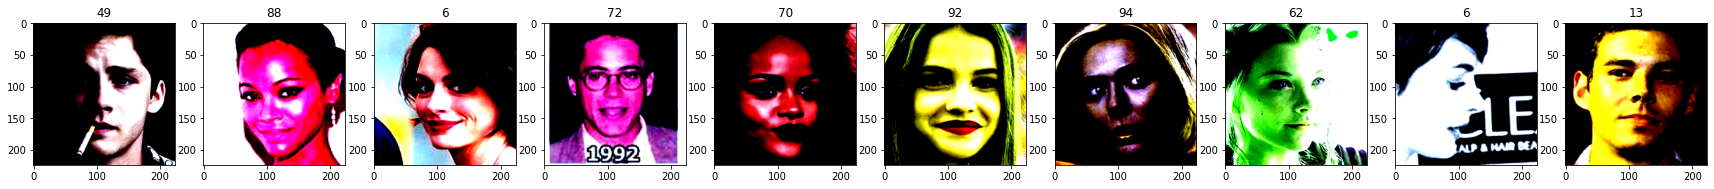

In [14]:
# посмотрим на пару из них
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

# FaceNet

In [15]:
#105
n_classes = len(train_df['classes'].unique())
#model
resnet = InceptionResnetV1(pretrained='vggface2',classify=False,num_classes=n_classes)
#mtcnn
mtcnn = MTCNN(
    image_size=240,  min_face_size=20,
     factor=0.709, post_process=False,
    device=device
)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [17]:
layers = list(resnet.children())[-5:]
#без последнего слоя branch2
model_ft = nn.Sequential(*list(resnet.children())[:-4])
model_ft

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [18]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

# нормализация аналогично vggface
class Normalize (nn.Module):
  def forward(self,input):
    return F.normalize(input,p=2,dim=1)

#network
class New_vgg (nn.Module):
  def __init__(self,out_features):
    super().__init__()
    self.resnet = model_ft
    for param in self.resnet.parameters(): # отключаем для нее обновление параметров
      param.requires_grad = False

    self.flatten = Flatten()
    self.normalize = Normalize()
    self.fc1 = nn.Linear(in_features=1792, out_features=512, bias=False)
    self.fc2 = nn.Linear(in_features=512, out_features=out_features, bias=True)
    self.softmax = nn.Softmax(dim=1)

  def forward(self,x):
    x = self.resnet(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.normalize(x)
    x = self.fc2(x)
    x = self.softmax(x)
    return x


In [19]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    FT_losses = []
    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # проверяем качество каждые 1500 батчей (~пол эпохи)
            if i % 1500 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            FT_losses.append(loss.item())
            # выведем текущий loss

            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Обучение закончено')
    return net,FT_losses

In [20]:
# model = New_vgg(105).to(device)
# net,FT_losses = train(model, n_epoch=10)


In [22]:
torch.cuda.empty_cache()
import gc
gc.collect()

model = New_vgg(105).to(device)
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

New_vgg(
  (resnet): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )


In [90]:
def test_model(test_loader,model):
  dataiter = iter(test_loader)
  images,labels = next(dataiter)
  images,labels  = images.to(device),labels.to(device)
  output = model(images)
  images = images.cpu()
  labels = labels.cpu().numpy()
  # преобразовать выходные вероятности в предсказанный класс
  _, preds_tensor = torch.max(output, 1)
  # предсказанные картинки
  preds = np.squeeze(preds_tensor.cpu().numpy())
  print('Accuracy: ',accuracy_score(labels, np.array(preds)))
  return preds

In [91]:
preds = test_model(test_loader,model)

Accuracy:  1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

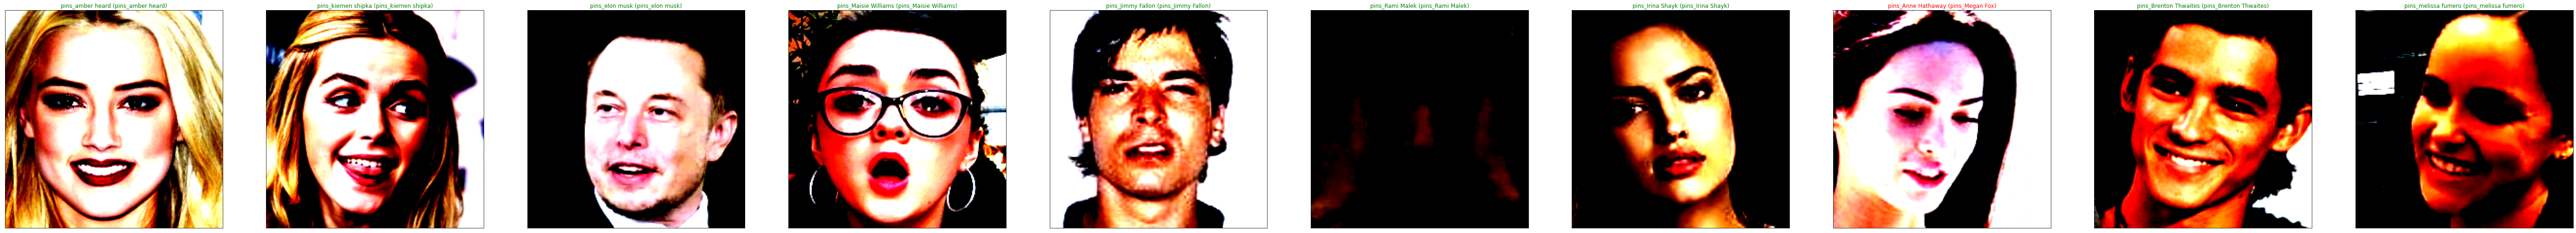

In [83]:
fig = plt.figure(figsize=(100, 20))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))